In [1]:
import importlib
import io
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageStat
import seaborn as sns
import SimpleITK as sitk
from skimage import io
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes
import staintools
from staintools import stain_normalizer, LuminosityStandardizer, ReinhardColorNormalizer
import sys

Image.MAX_IMAGE_PIXELS = None

In [2]:
print(sys.executable) 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

/gpfs1/scratch/90days/s4436005/envs/bin/python


In [35]:
# Paths #
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
HE_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/jpegs/HandE_2x')
HE_NORM_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/normalised/vahadane_2x')
TEMPLATE_SLIDE_PATH = SLIDES_PATH.joinpath('1957_T_9668_3_HandE.svs')
OUTPUT_PATH = Path('/QRISdata/Q1139/ST_Projects/HEMnet/Figure_Data/Stain_Normalisation')

# Parameters #
MAG = 2
VERBOSE = True

train_slide_prefixes = ['1820_', '2065_', '2112_', '2148_', '2171_N', '1957_T']

#Exclude slides that are not cancer (i.e. polpys, villous adenoma)
exclude_slide_prefixes = ['1794_T', '2107_T', '2171_T']

template_slide_prefix = '1957_T'

# Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi, bbox_inches = 'tight')
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

## Find H&E images 

In [11]:
# Find H&E images
he_img_names = []
for img in HE_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_img_names.append(name)
he_img_names.sort()
he_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [12]:
# Find H&E Normalised Images
he_norm_img_names = []
for img in HE_NORM_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_norm_img_names.append(name)
he_norm_img_names.sort()
he_norm_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [13]:
# Create DataFrame of original H&E and corresponding normalised H&E images
imgs_df = pd.DataFrame(list(zip(he_img_names, he_norm_img_names)), columns = ['original','norm'])
imgs_df

,original,norm
0,1792_T_9500_3_HandE_2x.jpeg,1792_T_9500_3_HandE_2x.jpeg
1,1794_T_9504_3_HandE_2x.jpeg,1794_T_9504_3_HandE_2x.jpeg
2,1798_T_9514_3_HandE_2x.jpeg,1798_T_9514_3_HandE_2x.jpeg
3,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
4,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
5,1843_T_9561_3_HandE_2x.jpeg,1843_T_9561_3_HandE_2x.jpeg
6,1879_T_9580_3_HandE_2x.jpeg,1879_T_9580_3_HandE_2x.jpeg
7,1910_T_9637_3_HandE_2x.jpeg,1910_T_9637_3_HandE_2x.jpeg
8,1915_T_10464_3_HandE_2x.jpeg,1915_T_10464_3_HandE_2x.jpeg
9,1919_T_10779_3_HandE_2x.jpeg,1919_T_10779_3_HandE_2x.jpeg


In [18]:
def not_exclude_slide(slide_name, exclude_slide_prefixes):
    """Check if slide should be excluded 
    
    True if slide name does not contain any exclude slide prefixes
    """
    is_exclude_slide = any([prefix in slide_name for prefix in exclude_slide_prefixes])
    return not is_exclude_slide

In [21]:
# Remove slides we do not want (i.e. polyps), as defined in exclude slide prefixes
imgs_df = imgs_df[imgs_df.original.apply(not_exclude_slide, args = (exclude_slide_prefixes,))]
imgs_df = imgs_df.reset_index(drop = True)
imgs_df

,original,norm
0,1792_T_9500_3_HandE_2x.jpeg,1792_T_9500_3_HandE_2x.jpeg
1,1798_T_9514_3_HandE_2x.jpeg,1798_T_9514_3_HandE_2x.jpeg
2,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
3,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
4,1843_T_9561_3_HandE_2x.jpeg,1843_T_9561_3_HandE_2x.jpeg
5,1879_T_9580_3_HandE_2x.jpeg,1879_T_9580_3_HandE_2x.jpeg
6,1910_T_9637_3_HandE_2x.jpeg,1910_T_9637_3_HandE_2x.jpeg
7,1915_T_10464_3_HandE_2x.jpeg,1915_T_10464_3_HandE_2x.jpeg
8,1919_T_10779_3_HandE_2x.jpeg,1919_T_10779_3_HandE_2x.jpeg
9,1928_T_9644_3_HandE_2x.jpeg,1928_T_9644_3_HandE_2x.jpeg


In [25]:
# Create DataFrame containing only training slide names
is_train_slide = lambda x: any([prefix in x for prefix in train_slide_prefixes])

imgs_train_df = imgs_df[imgs_df.original.apply(is_train_slide)]
imgs_train_df

,original,norm
2,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
3,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
12,1957_T_9668_3_HandE_2x.jpeg,1957_T_9668_3_HandE_2x.jpeg
18,2065_N_12752A_2_HandE_2x.jpeg,2065_N_12752A_2_HandE_2x.jpeg
19,2065_T_12756A_2_HandE_2x.jpeg,2065_T_12756A_2_HandE_2x.jpeg
22,2112_N_12341B_2_HandE_2x.jpeg,2112_N_12341B_2_HandE_2x.jpeg
23,2112_T_12335F_2_HandE_2x.jpeg,2112_T_12335F_2_HandE_2x.jpeg
24,2148_N_11397A_2_HandE_2x.jpeg,2148_N_11397A_2_HandE_2x.jpeg
25,2148_T_11393A_2_HandE_2x.jpeg,2148_T_11393A_2_HandE_2x.jpeg
26,2171_N_11521A_2_HandE_2x.jpeg,2171_N_11521A_2_HandE_2x.jpeg


In [29]:
# Create DataFrame containing only cancer slide names
is_cancer_slide = lambda x: '_T_' in x    # Cancer slides have a T in the slide name
filter_df = lambda df, column, func: (df[column.apply(func)]).reset_index(drop = True)
imgs_cancer_df = filter_df(imgs_df, imgs_df.original, is_cancer_slide)
imgs_cancer_df

,original,norm
0,1792_T_9500_3_HandE_2x.jpeg,1792_T_9500_3_HandE_2x.jpeg
1,1798_T_9514_3_HandE_2x.jpeg,1798_T_9514_3_HandE_2x.jpeg
2,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
3,1843_T_9561_3_HandE_2x.jpeg,1843_T_9561_3_HandE_2x.jpeg
4,1879_T_9580_3_HandE_2x.jpeg,1879_T_9580_3_HandE_2x.jpeg
5,1910_T_9637_3_HandE_2x.jpeg,1910_T_9637_3_HandE_2x.jpeg
6,1915_T_10464_3_HandE_2x.jpeg,1915_T_10464_3_HandE_2x.jpeg
7,1919_T_10779_3_HandE_2x.jpeg,1919_T_10779_3_HandE_2x.jpeg
8,1928_T_9644_3_HandE_2x.jpeg,1928_T_9644_3_HandE_2x.jpeg
9,1932_T_9876_3_HandE_2x.jpeg,1932_T_9876_3_HandE_2x.jpeg


## Plot image and histogram, before and after normalisation 

In [30]:
def plot_histogram(img, axes, ignore_background = False, alpha = 0.2):
    all_channels = img.ravel()
    red_channel = img[:, :, 0].ravel()
    green_channel = img[:, :, 1].ravel()
    blue_channel = img[:, :, 2].ravel()
    if ignore_background:
        background = np.logical_or(red_channel == 0, green_channel == 0, blue_channel == 0)
        non_background = np.invert(background)
        red_channel = red_channel[non_background]
        green_channel = green_channel[non_background]
        blue_channel = blue_channel[non_background]
        all_channels = np.concatenate([red_channel, green_channel, blue_channel])
    axes.hist(all_channels, bins = 256, color = 'orange', alpha = alpha)
    axes.hist(red_channel, bins = 256, color = 'red', alpha = alpha)
    axes.hist(green_channel, bins = 256, color = 'green', alpha = alpha)
    axes.hist(blue_channel, bins = 256, color = 'blue', alpha = alpha)
    axes.axvline(all_channels.mean(), color = 'orange')
    axes.axvline(red_channel.mean(), color = 'red')
    axes.axvline(green_channel.mean(), color = 'green')
    axes.axvline(blue_channel.mean(), color = 'blue')
    axes.set_xlabel('Intensity Value')
    axes.set_ylabel('Pixel Count')
    axes.legend(['Total_Mean','Red_Mean', 'Green_Mean', 'Blue_Mean', 'Total','Red_Channel', 'Green_Channel', 'Blue_Channel'])
    axes.set_xlim([0, 255])

In [60]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

In [58]:
REMOVE_BACKGROUND = False

# NUM = 0

# img_norm_name = imgs_df.norm.iloc[NUM]
# img_name = imgs_df.original.iloc[NUM]
# img_name = '1957_T_9668_3_HandE_2x.jpeg'
img_name = '1792_T_9500_3_HandE_2x.jpeg'
img_norm_name = img_name
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))
if REMOVE_BACKGROUND:
    img_pil, img_norm_pil = Image.fromarray(img), Image.fromarray(img_norm)
    img_pil = filter_grays(img_pil, replacement_col = (0, 0, 0)) 
    img_norm_pil = filter_grays(img_norm_pil, replacement_col = (0, 0, 0))
    img, img_norm = np.array(img_pil), np.array(img_norm_pil)

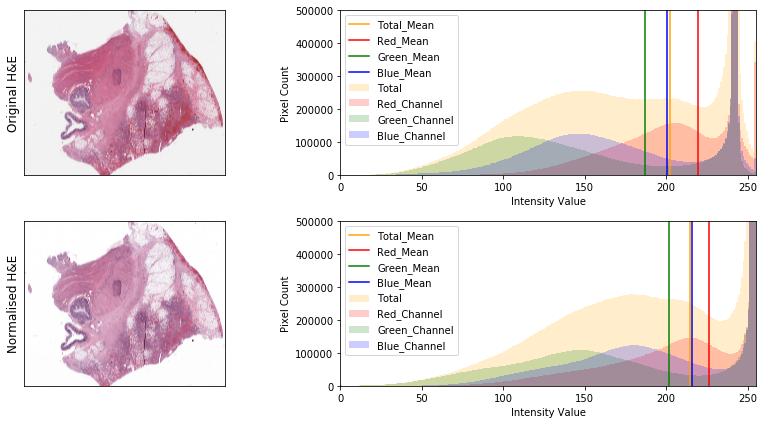

In [61]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,6))
axs[0,0].imshow(img, interpolation = 'bicubic')
plot_histogram(img, axs[0,1], ignore_background = REMOVE_BACKGROUND)
#axs[0,1].set_yscale('log', basey = 2)
axs[1,0].imshow(img_norm, interpolation = 'bicubic')
plot_histogram(img_norm, axs[1,1], ignore_background = REMOVE_BACKGROUND)
#axs[1,1].set_yscale('log', basey = 2)
axs[0,1].set_ylim([0, 500000])
axs[1,1].set_ylim([0, 500000])
axs[0,0].set_ylabel('Original H&E', size = 'large')
axs[1,0].set_ylabel('Normalised H&E', size = 'large')
for ax in [axs[0,0], axs[1,0]]:
    ax.set_yticks([])
    ax.set_xticks([])
#Remove X and Y ticks from images
#axs[0,0].set_tick_params(axis='both', which = 'both', bottom = False)
fig.tight_layout()
plt.show()
plt.rcParams['svg.fonttype'] = 'none'
# verbose_save_fig(fig, OUTPUT_PATH.joinpath('1957_T_Histogram.svg'))
verbose_save_fig(fig, OUTPUT_PATH.joinpath('1792_T_Histogram.svg'))

## Compare R, G, B and total channel mean intensities, before and after normalisation

In [46]:
# Create DataFrame to contain original image mean R, G, B and total channels

#og_means_df = imgs_train_df[['original']].copy()
og_means_df = imgs_df[['original']].copy()
og_means_df = og_means_df.rename(columns={'original':'img_name'})
og_means_df = og_means_df.reindex(og_means_df.columns.tolist() + ['red', 'green', 'blue', 'total'], axis = 1)
og_means_df.head()

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN
1,1798_T_9514_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN
2,1820_N_10545A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
3,1820_T_105452F_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
4,1843_T_9561_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN


In [47]:
# Create DataFrame to contain normalised image mean R, G, B and total channels

# norm_means_df = imgs_train_df[['norm']].copy()
norm_means_df = imgs_df[['norm']].copy()
norm_means_df = norm_means_df.rename(columns={'norm':'img_name'})
norm_means_df = norm_means_df.reindex(norm_means_df.columns.tolist() + ['red', 'green', 'blue', 'total'], axis = 1)
norm_means_df.head()

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN
1,1798_T_9514_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN
2,1820_N_10545A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
3,1820_T_105452F_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
4,1843_T_9561_3_HandE_2x.jpeg,NaN,NaN,NaN,NaN


In [48]:
def df_img_means(row, img_path, remove_background = False):
    """Calculate image R, G, B and total channel mean intensities 
    """
    img_name = row['img_name']
    img = io.imread(img_path.joinpath(img_name))
    if remove_background:
        img_pil = Image.fromarray(img)
        img_pil = filter_grays(img_pil, replacement_col = (0, 0, 0)) 
        img = np.array(img_pil)
    all_channels = img.ravel()
    red_channel = img[:, :, 0].ravel()
    green_channel = img[:, :, 1].ravel()
    blue_channel = img[:, :, 2].ravel()
    if remove_background:
        background = np.logical_or(red_channel == 0, green_channel == 0, blue_channel == 0)
        non_background = np.invert(background)
        red_channel = red_channel[non_background]
        green_channel = green_channel[non_background]
        blue_channel = blue_channel[non_background]
        all_channels = np.concatenate([red_channel, green_channel, blue_channel])
    row['total'] = all_channels.mean()
    row['red'] = red_channel.mean()
    row['green'] = green_channel.mean()
    row['blue'] = blue_channel.mean()
    return row

In [49]:
# Calculate R, G, B and total mean channel intensities for original H&E images
og_means_df = og_means_df.apply(df_img_means, axis = 1, args = (HE_JPEGS_PATH, REMOVE_BACKGROUND))
og_means_df

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,219.519846,186.787669,200.552479,202.286665
1,1798_T_9514_3_HandE_2x.jpeg,222.477441,188.162632,200.933893,203.857989
2,1820_N_10545A_2_HandE_2x.jpeg,220.866625,195.749549,209.567069,208.727748
3,1820_T_105452F_2_HandE_2x.jpeg,225.660951,211.060021,220.695259,219.138744
4,1843_T_9561_3_HandE_2x.jpeg,225.077515,207.001888,216.491101,216.190168
5,1879_T_9580_3_HandE_2x.jpeg,223.449557,205.793867,215.504877,214.916100
6,1910_T_9637_3_HandE_2x.jpeg,216.392317,196.482486,210.078224,207.651009
7,1915_T_10464_3_HandE_2x.jpeg,216.272686,190.983470,204.402393,203.886183
8,1919_T_10779_3_HandE_2x.jpeg,206.586466,177.665934,193.213338,192.488579
9,1928_T_9644_3_HandE_2x.jpeg,219.365325,190.019481,202.985872,204.123560


In [50]:
# Calculate R, G, B and total mean channel intensities for normalised H&E images
norm_means_df = norm_means_df.apply(df_img_means, axis = 1, args = (HE_NORM_JPEGS_PATH, REMOVE_BACKGROUND))
norm_means_df

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,226.211019,201.560859,216.155942,214.642607
1,1798_T_9514_3_HandE_2x.jpeg,229.453510,201.856835,215.357331,215.555892
2,1820_N_10545A_2_HandE_2x.jpeg,225.418794,202.371464,217.558289,215.116182
3,1820_T_105452F_2_HandE_2x.jpeg,231.721280,215.374365,226.126283,224.407309
4,1843_T_9561_3_HandE_2x.jpeg,233.429616,216.039392,226.277222,225.248743
5,1879_T_9580_3_HandE_2x.jpeg,233.618048,217.787440,227.644195,226.349894
6,1910_T_9637_3_HandE_2x.jpeg,227.091588,204.677838,218.235894,216.668440
7,1915_T_10464_3_HandE_2x.jpeg,225.813379,202.489057,216.947719,215.083385
8,1919_T_10779_3_HandE_2x.jpeg,223.966744,198.038631,212.984467,211.663281
9,1928_T_9644_3_HandE_2x.jpeg,228.238412,202.381489,216.019347,215.546416


In [ ]:
# is_train_slide = lambda x: any([prefix in x for prefix in train_slide_prefixes])
# is_template_slide = lambda row: template_slide_prefix in row['img_name']

# og_means_df['img_name'] = og_means_df['img_name'].astype(np.str)
# og_template_means_df = og_means_df[og_means_df.img_name.apply(lambda x: x in template_slide_prefix)]
# og_template_means_df

In [51]:
template_slide_prefix

'1957_T'

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

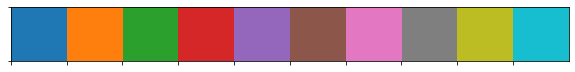

In [62]:
# Visualise current colour palette for plotting
current_palette = sns.color_palette()
sns.palplot(current_palette)
current_palette.as_hex()

In [53]:
# Extract R, G, B and total mean channel intensities for original template image
og_template_mean_df = og_means_df[og_means_df['img_name']=='1957_T_9668_3_HandE_2x.jpeg'].drop('img_name', axis = 1)
og_template_mean_df 

,red,green,blue,total
12,219.792326,198.902405,211.532544,210.075758


In [56]:
# Extract R, G, B and total mean channel intensities for normalised template image
norm_template_mean_df = norm_means_df[norm_means_df['img_name']=='1957_T_9668_3_HandE_2x.jpeg'].drop('img_name', axis = 1)
norm_template_mean_df

,red,green,blue,total
12,228.747678,208.30676,220.974662,219.343034


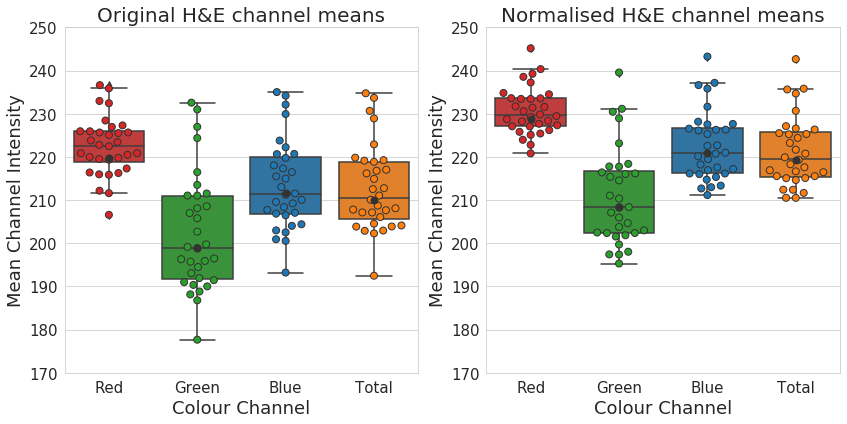

In [81]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
palette = {'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4', 'total': '#ff7f0e'}

sns.set_style("whitegrid")
#Settings to apply to all axis
for ax in axs:
    ax.set_ylim([170, 250])
    ax.set_ylabel('Mean Channel Intensity', fontsize = 18)
    ax.set_xlabel('Colour Channel', fontsize = 18)
    
    
sns.boxplot(data = og_means_df[['red','green', 'blue', 'total']], palette = palette, ax = axs[0])
sns.swarmplot(data = og_means_df[['red','green', 'blue', 'total']], palette = palette, ax = axs[0],
               size = 7, edgecolor = "0.2", linewidth=1)
sns.boxplot(data = norm_means_df[['red','green', 'blue', 'total']], palette = palette, ax = axs[1])
sns.swarmplot(data = norm_means_df[['red','green', 'blue', 'total']], palette = palette, ax = axs[1],
              size = 7, edgecolor = "0.2", linewidth=1)

axs[0].set_title('Original H&E channel means', fontsize = 20)
axs[1].set_title('Normalised H&E channel means', fontsize = 20)



sns.swarmplot(data = og_template_mean_df, ax = axs[0], size = 7, color = '0.2', edgecolor = '0.2', linewidth = 1)
sns.swarmplot(data = norm_template_mean_df, ax = axs[1], size = 7, color = '0.2', edgecolor = '0.2', linewidth = 1)

axs[0].set_xticklabels(['Red', 'Green', 'Blue', 'Total'], fontsize = 15)
axs[1].set_xticklabels(['Red', 'Green', 'Blue', 'Total'], fontsize = 15)
axs[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
axs[1].tick_params(axis = 'both', which = 'major', labelsize = 15)


fig.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('original_vs_normalised_HE_channel_means.svg'))

## Compare the mean R, G, B and total channel intensy of each cancer image to the median intensities of all images

In [83]:
# Calculate the median channel intensites of all original images
og_means_medians = og_means_df.median()
og_means_medians

red      222.630352
green    199.019717
blue     211.398006
total    210.568506
dtype: float64

In [85]:
# Calculate the median channel intensities of all normalised images
norm_means_medians = norm_means_df.median()
norm_means_medians

red      229.643572
green    208.346902
blue     220.853562
total    219.626752
dtype: float64

In [87]:
def abs_diff_from_median(x, medians):
    x['red'] = abs(x['red'] - medians['red'])
    x['green'] = abs(x['green'] - medians['green'])
    x['blue'] = abs(x['blue'] - medians['blue'])
    x['total'] = abs(x['total'] - medians['total'])
    return x

In [89]:
# Calculate the absolute difference of each image's channel intensity from the median intensity of original images
og_means_diff = og_means_df.apply(abs_diff_from_median, axis = 1, args = (og_means_medians,))

# Select for only cancer slides
og_cancer_means_diff = filter_df(og_means_diff, og_means_diff.img_name, is_cancer_slide)
og_cancer_means_diff

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,3.110505,12.232048,10.845527,8.281841
1,1798_T_9514_3_HandE_2x.jpeg,0.152910,10.857085,10.464113,6.710517
2,1820_T_105452F_2_HandE_2x.jpeg,3.030599,12.040304,9.297253,8.570238
3,1843_T_9561_3_HandE_2x.jpeg,2.447163,7.982171,5.093095,5.621662
4,1879_T_9580_3_HandE_2x.jpeg,0.819205,6.774150,4.106871,4.347595
5,1910_T_9637_3_HandE_2x.jpeg,6.238035,2.537231,1.319782,2.917497
6,1915_T_10464_3_HandE_2x.jpeg,6.357665,8.036247,6.995613,6.682323
7,1919_T_10779_3_HandE_2x.jpeg,16.043885,21.353783,18.184668,18.079926
8,1928_T_9644_3_HandE_2x.jpeg,3.265027,9.000236,8.412134,6.444946
9,1932_T_9876_3_HandE_2x.jpeg,9.815689,25.352074,18.536450,18.348924


In [90]:
norm_means_diff = norm_means_df.apply(abs_diff_from_median, axis = 1, args = (norm_means_medians,))
norm_cancer_means_diff = filter_df(norm_means_diff, norm_means_diff.img_name, is_cancer_slide)
norm_cancer_means_diff

,img_name,red,green,blue,total
0,1792_T_9500_3_HandE_2x.jpeg,3.432552,6.786044,4.697620,4.984145
1,1798_T_9514_3_HandE_2x.jpeg,0.190061,6.490067,5.496230,4.070859
2,1820_T_105452F_2_HandE_2x.jpeg,2.077708,7.027463,5.272722,4.780558
3,1843_T_9561_3_HandE_2x.jpeg,3.786044,7.692490,5.423661,5.621992
4,1879_T_9580_3_HandE_2x.jpeg,3.974476,9.440538,6.790633,6.723143
5,1910_T_9637_3_HandE_2x.jpeg,2.551983,3.669064,2.617668,2.958312
6,1915_T_10464_3_HandE_2x.jpeg,3.830193,5.857845,3.905842,4.543367
7,1919_T_10779_3_HandE_2x.jpeg,5.676828,10.308271,7.869095,7.963471
8,1928_T_9644_3_HandE_2x.jpeg,1.405159,5.965414,4.834214,4.080336
9,1932_T_9876_3_HandE_2x.jpeg,9.612021,20.599427,14.973215,15.049481


In [91]:
og_template_mean_diff = og_means_diff[og_means_diff['img_name']=='1957_T_9668_3_HandE_2x.jpeg'].drop('img_name', axis = 1)
og_template_mean_diff

,red,green,blue,total
12,2.838026,0.117312,0.134538,0.492748


In [92]:
norm_template_mean_diff = norm_means_diff[norm_means_diff['img_name']=='1957_T_9668_3_HandE_2x.jpeg'].drop('img_name', axis = 1)
norm_template_mean_diff

,red,green,blue,total
12,0.895893,0.040142,0.121101,0.283718


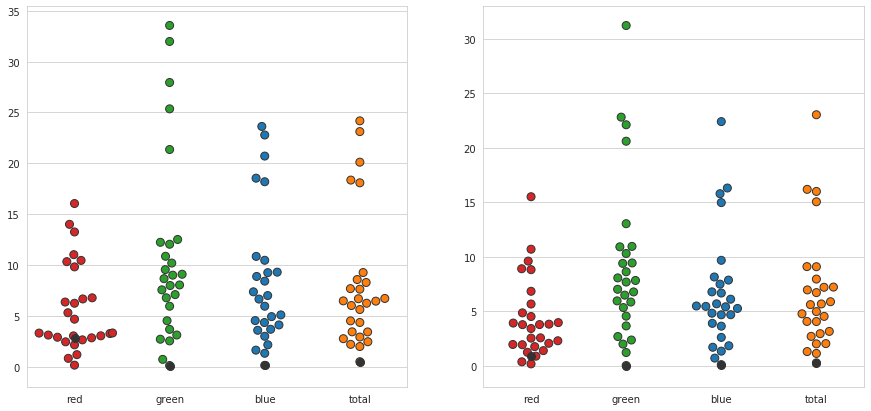

In [93]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))
palette = {'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4', 'total': '#ff7f0e'}
sns.swarmplot(data = og_cancer_means_diff[['red','green', 'blue', 'total']], palette = palette, ax = axs[0],
               size = 8, edgecolor = "0.2", linewidth=1)
sns.swarmplot(data = norm_cancer_means_diff[['red','green', 'blue', 'total']], palette = palette, ax = axs[1],
              size = 8, edgecolor = "0.2", linewidth=1)

sns.swarmplot(data = og_template_mean_diff, ax = axs[0], size = 8, color = '0.2', edgecolor = '0.2', linewidth = 1)
sns.swarmplot(data = norm_template_mean_diff, ax = axs[1], size = 8, color = '0.2', edgecolor = '0.2', linewidth = 1)

In [94]:
sns.swarmplot(data = og_cancer_means_diff[['red','green', 'blue', 'total']], ax = axs[0],
               size = 8, edgecolor = "0.2", linewidth=1)
plt.show()

In [96]:
# fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))
# sns.swarmplot(data = og_means_diff[['red','green', 'blue', 'total']], hue = og_means_diff[['img_name']], ax = axs[0],
#                size = 8, edgecolor = "0.2", linewidth=1)
# sns.swarmplot(data = norm_means_diff[['red','green', 'blue', 'total']], ax = axs[1],
#               size = 8, edgecolor = "0.2", linewidth=1)

# sns.swarmplot(data = og_template_mean_diff, ax = axs[0], size = 8, color = '0.2', edgecolor = '0.2', linewidth = 1)
# sns.swarmplot(data = norm_template_mean_diff, ax = axs[1], size = 8, color = '0.2', edgecolor = '0.2', linewidth = 1)

In [97]:
og_template_mean_diff = og_means_diff[og_means_diff['img_name']=='1957_T_9668_3_HandE_2x.jpeg']
og_template_mean_diff

,img_name,red,green,blue,total
12,1957_T_9668_3_HandE_2x.jpeg,2.838026,0.117312,0.134538,0.492748


In [98]:
og_cancer_means_diff = og_cancer_means_diff.sort_values('total')

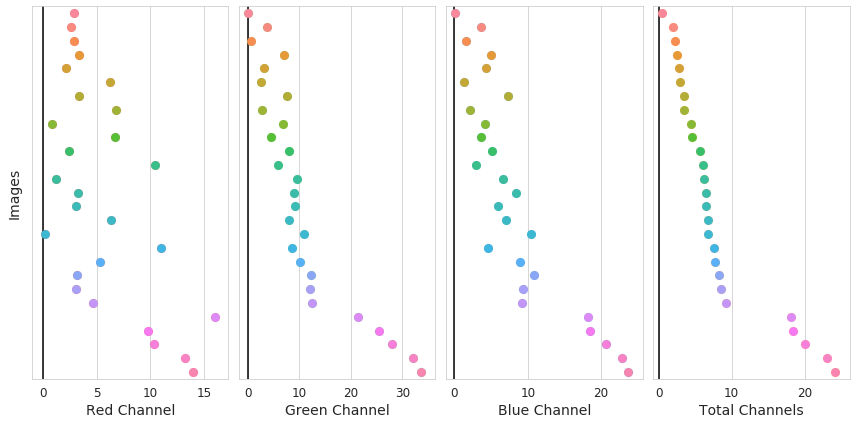

In [107]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12,6))
columns = ['red', 'green', 'blue', 'total']
palette = {'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4', 'total': '#ff7f0e'}
column_name = {'red': 'Red Channel', 'green': 'Green Channel', 'blue': 'Blue Channel', 'total': 'Total Channels'}
for column in columns:
    i = columns.index(column)
    sns.swarmplot(data = og_cancer_means_diff, x = column, y = 'img_name', ax = axs[i],
               size = 9, edgecolor = palette[column], linewidth=0.1)
    axs[i].axvline(0, color = 'black')
    axs[i].tick_params(axis = 'x', labelsize = 12)
    axs[i].set_xlabel(column_name[column], size = 14)
#     if i != 0:
    if True:
        axs[i].set_yticklabels([])
        axs[i].set_ylabel('')
axs[0].tick_params(axis = 'y', labelsize = 12)
axs[0].set_ylabel('Images', size = 14)
#axs[0].set_xtickslabels(axs[0].get_xticklabels(), rotation = 90)
#sns.swarmplot(data = og_template_mean_diff, x = 'img_name', y = 'red', ax = axs[0], size = 8, color = '0.2', edgecolor = '0.2', linewidth = 1)
for label in axs[0].get_yticklabels():
    label.set_verticalalignment('center')
fig.tight_layout()
plt.show()
plt.rcParams['svg.fonttype'] = 'none'
verbose_save_fig(fig, OUTPUT_PATH.joinpath('abs_diff_cancer_imgs_to_median_of_all_imgs.svg'))

### Remove Background

In [30]:
def filter_grays(img, tolerance = 3, replacement_col = (255,255,255)):
    """Replaces gray pixels greater than threshold with pixels of a certain colour - default is white
    
    Used to remove background from tissue images
    """
    img = img.convert('RGB')
    r, g, b = img.split()
    rg_diff = np.array(ImageChops.difference(r,g)) <= tolerance
    rb_diff = np.array(ImageChops.difference(r,b)) <= tolerance
    gb_diff = np.array(ImageChops.difference(g,b)) <= tolerance
    grays = (rg_diff & rb_diff & gb_diff)*255
    grays_mask = Image.fromarray(grays.astype(np.uint8), 'L')
    col_image = Image.new('RGB', img.size, replacement_col)
    img_filtered = img.copy()
    img_filtered.paste(col_image, mask = grays_mask)
    return img_filtered

In [180]:
NUM = 0
img_norm_name = imgs_train_df.norm.iloc[NUM]
img_name = imgs_train_df.original.iloc[NUM]
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))

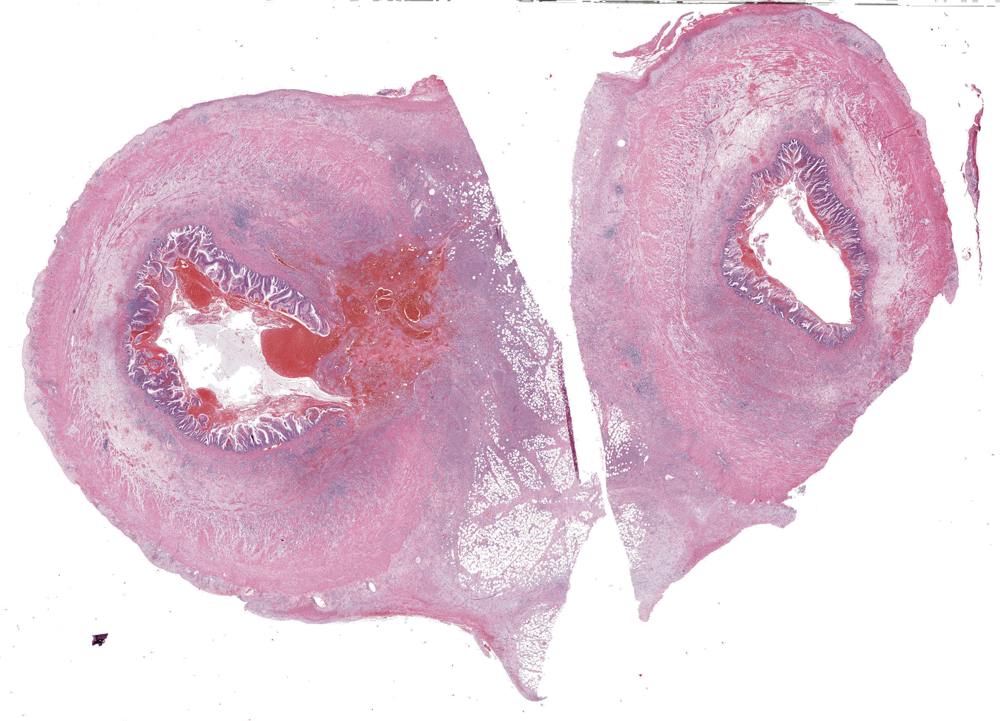

In [182]:
img_pil = Image.fromarray(img)
thumbnail(filter_grays(img_pil, replacement_col = (255, 255, 255)))